In [2]:
 # Installing required libraries
!pip install transformers datasets huggingface_hub mlflow evaluate gradio
!pip install -q transformers-interpret

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/

In [3]:
# Importing required libraries
import pandas as pd
import numpy as np
import re
import torch
import mlflow
from sklearn.model_selection import train_test_split
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    AutoTokenizer,
    AutoModelForSequenceClassification
)
from sklearn.metrics import roc_auc_score, confusion_matrix
from transformers.integrations import MLflowCallback
from datasets import Dataset, load_dataset, concatenate_datasets
import matplotlib.pyplot as plt
import seaborn as sns
import evaluate
import wandb
from transformers_interpret import SequenceClassificationExplainer
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dahalaamosh (dahalaamosh-harrisburg-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# ---------------------------
# MLflow Setup
# ---------------------------
mlflow.set_experiment("Phishing_Detection_DistilBERT_Uncased")

2025/03/26 01:36:00 INFO mlflow.tracking.fluent: Experiment with name 'Phishing_Detection_DistilBERT_Uncased' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/399934098347173591', creation_time=1742952960114, experiment_id='399934098347173591', last_update_time=1742952960114, lifecycle_stage='active', name='Phishing_Detection_DistilBERT_Uncased', tags={}>

In [ ]:
# ---------------------------
# Data Loading and Preprocessing
# ---------------------------
# Loading phishing email dataset from the drive.
df = pd.read_csv("/content/drive/MyDrive/Masters Research/phishing_email.csv")
print("Dataset shape:", df.shape)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)          # removing extra whitespace
    text = re.sub(r'[^\w\s]', '', text)         # removing punctuation
    return text.strip()

df['text_combined'] = df['text_combined'].apply(clean_text)
df.drop_duplicates(inplace=True)
df.dropna(subset=['text_combined', 'label'], inplace=True)

Dataset shape: (82486, 2)


In [ ]:
# ---------------------------
# Random Undersampling for Balanced Classes
# ---------------------------
# According to your methodology, use Random UnderSampling (RUS) to balance classes.
# Determine the minimum count among the classes.
min_count = df['label'].value_counts().min()
balanced_df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(min_count, random_state=42))
print("Balanced dataset shape:", balanced_df.shape)
print("Class distribution after undersampling:")
print(balanced_df['label'].value_counts())

Balanced dataset shape: (78466, 2)
Class distribution after undersampling:
label
0    39233
1    39233
Name: count, dtype: int64


<ipython-input-7-dc8d4441bbe3>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(min_count, random_state=42))


In [ ]:
# Splitting data into training and testing sets (80/20 split, stratified)
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label']
)
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

Training set shape: (65662, 2)
Testing set shape: (16416, 2)


In [ ]:
# Converting pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
# ---------------------------
# Tokenization and Dataset Preparation
# ---------------------------
model_checkpoint = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(example):
    return tokenizer(
        example["text_combined"],
        padding="max_length",
        truncation=True,
        max_length=256  # adjust based on your data
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/65662 [00:00<?, ? examples/s]

Map:   0%|          | 0/16416 [00:00<?, ? examples/s]

In [ ]:
# ---------------------------
# Model Setup and Fine-Tuning with MLflow Logging
# ---------------------------
model = DistilBertForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=True
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Loading metrics using the Hugging Face 'datasets' library
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Computing metrics using Hugging Face's load_metric
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    precision = precision_metric.compute(predictions=predictions, references=labels, average="binary")["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels, average="binary")["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="binary")["f1"]

    # Computing ROC-AUC using probabilities
    from scipy.special import softmax
    probabilities = softmax(logits, axis=1)
    probs_phishing = probabilities[:, 1]
    try:
        roc_auc = roc_auc_score(labels, probs_phishing)
    except ValueError:
        roc_auc = float("nan")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc
    }


In [ ]:
# Initializing the Trainer with the MLflow callback and the updated compute_metrics function
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Model, tokenizer, and training metrics (including evaluation metrics and confusion matrix) have been logged and pushed to the Hugging Face Hub!


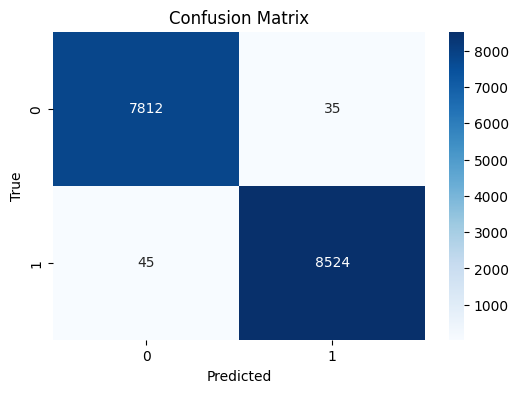

In [ ]:
# ---------------------------
# Fine-Tuning and MLflow Run with Extended Evaluation
# ---------------------------
with mlflow.start_run():
    # Fine-tuning the model
    trainer.train()

    # Evaluating the model on the test dataset
    eval_results = trainer.evaluate()

    # Logging all evaluation metrics to MLflow
    for key, value in eval_results.items():
        mlflow.log_metric(key, value)

    # Computing and log the confusion matrix as an artifact
    predictions_output = trainer.predict(test_dataset)
    preds = np.argmax(predictions_output.predictions, axis=-1)
    cm = confusion_matrix(predictions_output.label_ids, preds)

    # Plotting and saving the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Push the fine-tuned model and tokenizer to your Hugging Face Hub repository
    model.push_to_hub("aamoshdahal/email-phishing-distilbert-finetuned")
    tokenizer.push_to_hub("aamoshdahal/email-phishing-distilbert-finetuned")

    # Log additional training outputs as artifacts
    mlflow.log_artifact("./results")

    print("Model, tokenizer, and training metrics (including evaluation metrics and confusion matrix) have been logged and pushed to the Hugging Face Hub!")

In [ ]:
mlflow.end_run()

In [ ]:
# -------------------------------
# 🧹 LOADING & CLEANING DATASET (NEW VERSION)
# -------------------------------
dataset = load_dataset("cybersectony/PhishingEmailDetectionv2.0")

# Keep only email examples (labels 0 and 1)
keep_labels = [0, 1]

filtered_test = dataset["test"].filter(lambda x: x["label"] in keep_labels)

test_data = filtered_test.rename_column("content", "text")  # rename for consistency


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/27.9M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/3.17M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/9.21M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/60000 [00:00<?, ? examples/s]

In [ ]:
# ---------------------------------------------------
# 📏 METRIC FUNCTIONS
# ---------------------------------------------------
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(preds, labels, probs=None):
    acc = accuracy.compute(predictions=preds, references=labels)["accuracy"]
    prec = precision.compute(predictions=preds, references=labels)["precision"]
    rec = recall.compute(predictions=preds, references=labels)["recall"]
    f1_score = f1.compute(predictions=preds, references=labels)["f1"]
    roc = roc_auc_score(labels, probs) if probs is not None else float('nan')
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1_score,
        "roc_auc": roc
    }

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Map:   0%|          | 0/6799 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6799 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6799 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


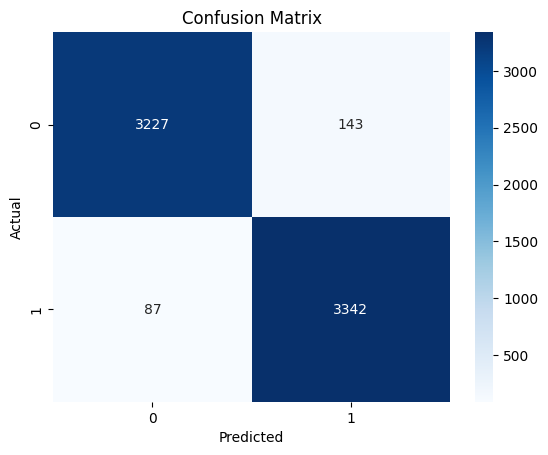

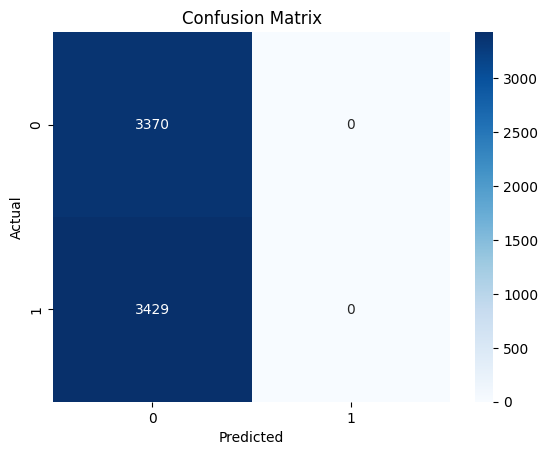

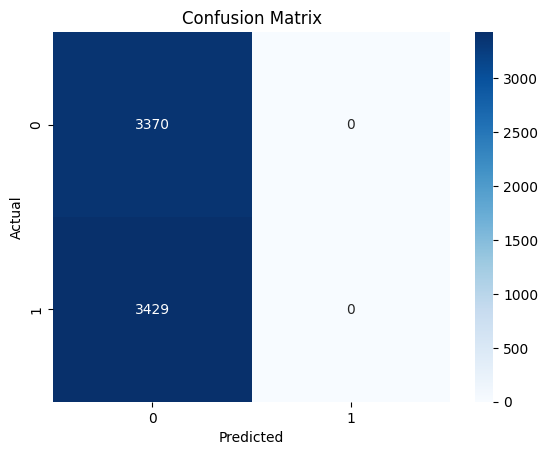

In [ ]:


# ---------------------------------------------------
# 🚀 BENCHMARKING EACH MODEL
# ---------------------------------------------------
models_to_test = {
    "Fine-tuned DistilBERT v1": "aamoshdahal/email-phishing-distilbert-finetuned",
    "Raw DistilBERT": "distilbert-base-uncased",
    "Raw BERT": "bert-base-uncased"
}

for model_name, model_id in models_to_test.items():
    wandb.init(project="Phishing_Detection_DistilBERT_Uncased", name= "BENCHMARK" + model_name)

    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Tokenize test dataset
    def tokenize(example):
        return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

    tokenized = test_data.map(tokenize, batched=True)
    tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

    dataloader = torch.utils.data.DataLoader(tokenized, batch_size=32)
    preds, probs, labels = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            outputs = model(input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device))
            logits = outputs.logits
            softmaxed = torch.nn.functional.softmax(logits, dim=1)
            probs.extend(softmaxed[:,1].cpu().numpy())
            preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
            labels.extend(batch["label"].cpu().numpy())

    # Log metrics
    metrics = compute_metrics(preds, labels, probs)
    wandb.log(metrics)

    # Confusion matrix
    cm = confusion_matrix(labels, preds)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title("Confusion Matrix")
    fig.savefig("conf_matrix.png")
    wandb.log({"confusion_matrix": wandb.Image("conf_matrix.png")})

    wandb.finish()

In [ ]:
model_id = "aamoshdahal/email-phishing-distilbert-finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
phishing_examples = test_data.filter(lambda x: x["label"] == 1).select(range(5))
legit_examples = test_data.filter(lambda x: x["label"] == 0).select(range(5))
sample_data = concatenate_datasets([phishing_examples, legit_examples])

In [ ]:
# -----------------------------------
# ⚙️ Initializing Explainer
# -----------------------------------
explainer = SequenceClassificationExplainer(
    model=model,
    tokenizer=tokenizer
)

In [ ]:
wandb.init(project="Phishing_Detection_DistilBERT_Uncased", name="Phishing_Model_Interpretability")

In [ ]:
for i, example in enumerate(sample_data):
    original_text = example["text"]
    encoded = tokenizer.encode(original_text, max_length=512, truncation=True)
    text = tokenizer.decode(encoded, skip_special_tokens=True)

    true_label = "Phishing" if example["label"] == 1 else "Legit"

    # Run the explanation
    word_attributions = explainer(text, class_name="POSITIVE")

    # Get model prediction and confidence
    prediction = explainer.predicted_class_name

    html_output = explainer.visualize()

    # Create explanation string
    explanation = f"""
    ➤ True Label: {true_label}
    ➤ Predicted Label: {prediction}
    ➤ Top Influential Tokens: {[w for w, score in word_attributions[:5]]}
    """

    wandb.log({
        f"Sample {i} - Attribution": wandb.Html(html_output.data),
        f"Sample {i} - Explanation": wandb.Html(f"<pre>{explanation}</pre>")
    })

wandb.finish()

/usr/local/lib/python3.11/dist-packages/transformers_interpret/explainers/text/sequence_classification.py:220: UserWarning: 'POSITIVE' is not found in self.label2id keys.Defaulting to predicted index instead.
  warnings.warn(s)


In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 97.1 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers_interpret import SequenceClassificationExplainer

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Initialize explainer (still runs on CPU)
explainer = SequenceClassificationExplainer(model=model, tokenizer=tokenizer)

# Inference & attribution function
def classify_and_explain(email_text):
    # Truncate to 512 tokens
    encoded = tokenizer.encode_plus(
        email_text,
        max_length=512,
        truncation=True,
        return_tensors="pt"
    )
    input_ids = encoded["input_ids"].to(device)
    attention_mask = encoded["attention_mask"].to(device)

    # Inference on GPU
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_idx = torch.argmax(probs, dim=-1).item()
        confidence = float(probs[0][pred_idx].item()) * 100
        prediction = "Phishing" if pred_idx == 1 else "Legit"

    # Attribution (on CPU)
    word_attributions = explainer(email_text)
    html = explainer.visualize().data

    explanation = f"""
    <b>Prediction:</b> {prediction}<br>
    <b>Confidence:</b> {confidence:.2f}%<br>
    <b>Top Influential Tokens:</b> {', '.join([w for w, _ in word_attributions[:5]])}
    <br><br>
    <b>Token Attribution Visualization:</b>
    """

    return explanation + html

# Gradio UI
interface = gr.Interface(
    fn=classify_and_explain,
    inputs=gr.Textbox(lines=8, label="Enter an Email Message"),
    outputs=gr.HTML(label="Prediction & Explanation"),
    title="Phishing Email Detector (with Explanation)",
    description="This model detects phishing emails and highlights why it made its decision."
)

# Launch the app
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://eb2f812438d1ce954e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [4]:
model_id = "aamoshdahal/email-phishing-distilbert-finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

email = "Password expiring soon Hi John, Your password is due to expire in 3 days. Reset Password. Netflix are requesting all its customers perform a password reset due to a recent increase in account compromises.– Your friends at Netflix. Questions? Visit the Help Centre Netflix Productions Communication Settings | Terms of Use | Privacy | Help Centre This message was emailed to john[.]doe@mybusiness[.]com by Netflix."


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Prediction: Legitimate (79.52%)


In [5]:
encoded_input = tokenizer(email, return_tensors='pt').to(device)
print(encoded_input)

{'input_ids': tensor([[  101, 20786,  4654,  8197,  4892,  2574,  7632,  2198,  1010,  2115,
         20786,  2003,  2349,  2000,  4654, 20781,  1999,  1017,  2420,  1012,
         25141, 20786,  1012, 20907,  2024, 17942,  2035,  2049,  6304,  4685,
          1037, 20786, 25141,  2349,  2000,  1037,  3522,  3623,  1999,  4070,
         12014,  2015,  1012,  1516,  2115,  2814,  2012, 20907,  1012,  3980,
          1029,  3942,  1996,  2393,  2803, 20907,  5453,  4807, 10906,  1064,
          3408,  1997,  2224,  1064,  9394,  1064,  2393,  2803,  2023,  4471,
          2001, 10373,  2098,  2000,  2198,  1031,  1012,  1033, 18629,  1030,
          2026,  8286,  9961,  1031,  1012,  1033,  4012,  2011, 20907,  1012,
           102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [6]:
with torch.no_grad():
    outputs = model(**encoded_input)
    print(outputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    print(probs)

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.7272, -0.6292]]), hidden_states=None, attentions=None)
tensor([[0.7952, 0.2048]])


In [7]:
print(probs)

tensor([[0.7952, 0.2048]])


In [ ]:
# Interpret prediction
classes = ["Legitimate", "Phishing"]
predicted_class = classes[probs.argmax().item()]
confidence = probs.max().item() * 100

print(f"Prediction: {predicted_class} ({confidence:.2f}%)")

In [16]:
explainer = SequenceClassificationExplainer(model=model, tokenizer=tokenizer)
word_attributions = explainer(email, class_name="LABEL_0")
explainer.visualize()

In [17]:
word_attributions

[('[CLS]', 0.0),
 ('password', -0.6584935368247553),
 ('ex', -0.016096638953366806),
 ('##pi', -0.09679396314947572),
 ('##ring', 0.04511456544398028),
 ('soon', -0.06375867317153126),
 ('hi', -0.06454119791402434),
 ('john', -0.06979064677345267),
 (',', 0.05238094385514885),
 ('your', -0.0687231076960405),
 ('password', -0.087143943581909),
 ('is', -0.03634787810189909),
 ('due', -0.033864031314221055),
 ('to', -0.1006642704246587),
 ('ex', -0.015576103360377503),
 ('##pire', 0.034016128882421136),
 ('in', -0.021700430507147952),
 ('3', 0.011846070184070663),
 ('days', -0.05449521533872411),
 ('.', 0.05280968932392504),
 ('reset', -0.17589026172979355),
 ('password', -0.1516612715118704),
 ('.', -0.059120679663636426),
 ('netflix', -0.08696573141504926),
 ('are', -0.05696026979528064),
 ('requesting', -0.002930773077239026),
 ('all', 0.011186463862435216),
 ('its', -0.014034169454396084),
 ('customers', -0.08327236559580678),
 ('perform', -0.008433820382519793),
 ('a', -0.16436986250